# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


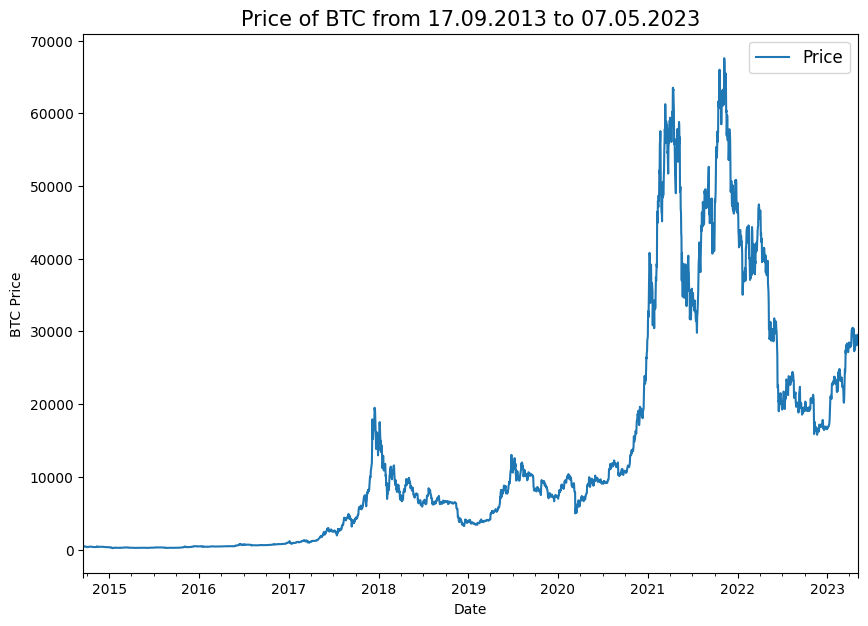

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

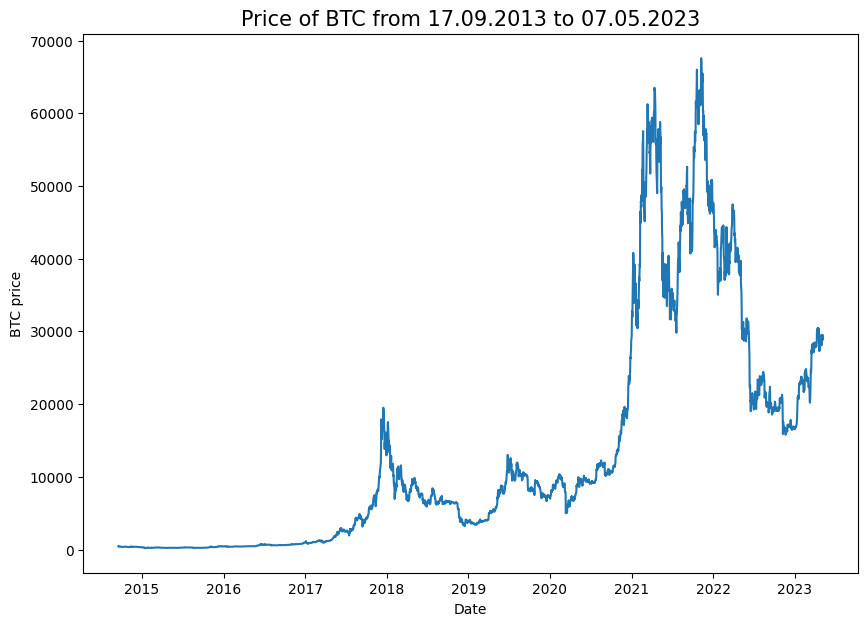

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

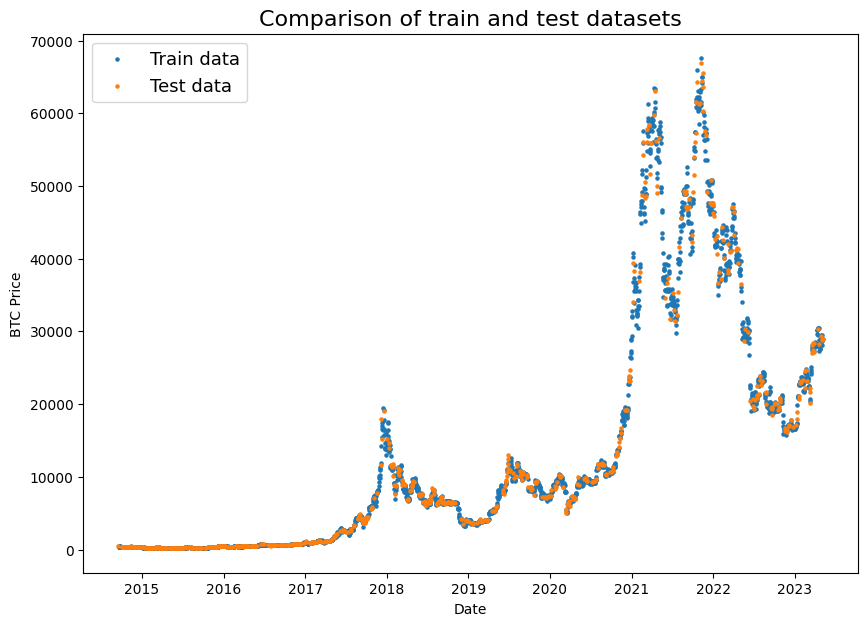

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

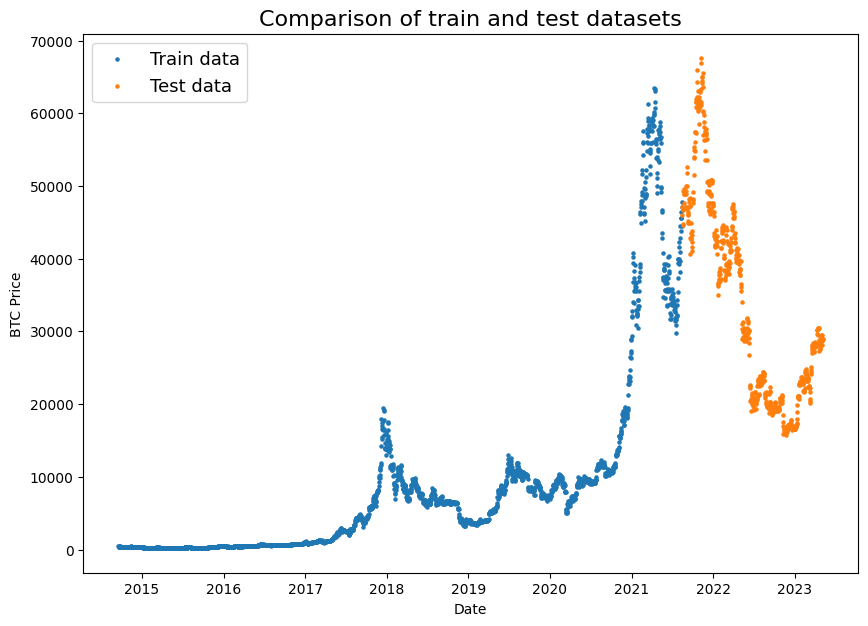

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

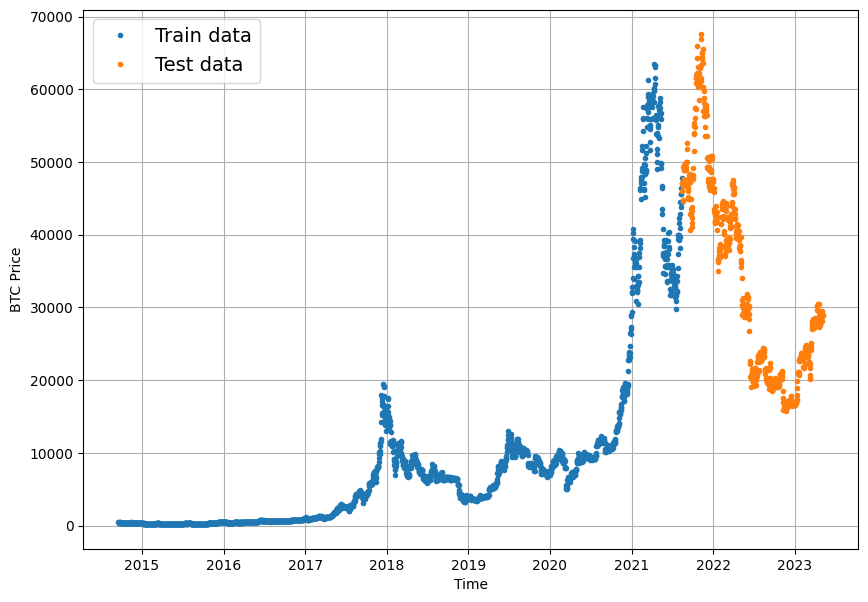

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

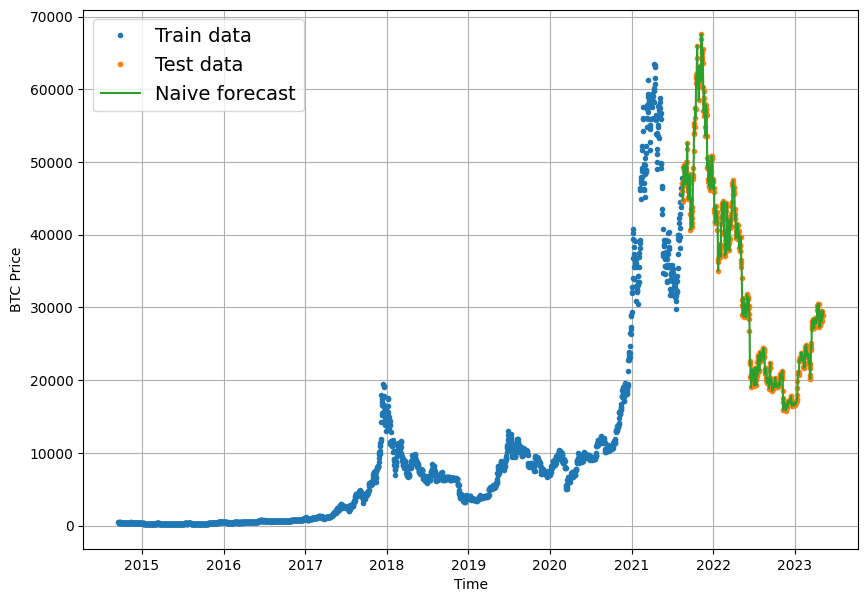

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

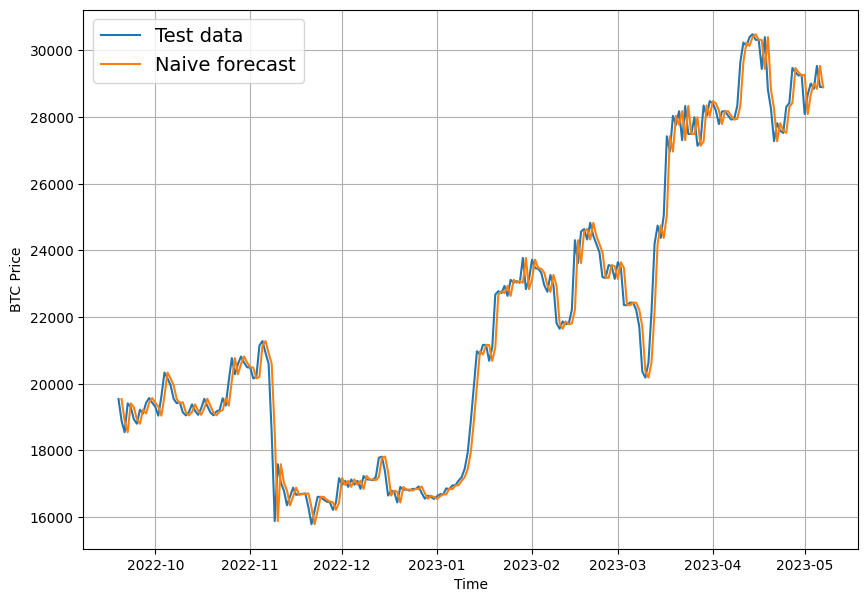

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
66/79 [========================>.....] - ETA: 0s - loss: 2554.9775 - mae: 2554.9775 - mse: 58675172.0000
Epoch 1: val_loss improved from inf to 1797.72498, saving model to model_experiments/model_1_dense


79/79 [==============================] - 8s 14ms/step - loss: 2241.7271 - mae: 2241.7271 - mse: 49507728.0000 - val_loss: 1797.7250 - val_mae: 1797.7250 - val_mse: 6353263.0000
Epoch 2/100
75/79 [===========================>..] - ETA: 0s - loss: 568.0329 - mae: 568.0329 - mse: 1801231.7500
Epoch 2: val_loss improved from 1797.72498 to 1724.49304, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 561.6115 - mae: 561.6115 - mse: 1755890.1250 - val_loss: 1724.4930 - val_mae: 1724.4930 - val_mse: 5606020.5000
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 472.0459 - mae: 472.0459 - mse: 1193915.1250
Epoch 3: val_loss improved from 1724.49304 to 1262.28149, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 15ms/step - loss: 473.3245 - mae: 473.3245 - mse: 1195014.0000 - val_loss: 1262.2815 - val_mae: 1262.2815 - val_mse: 3250896.7500
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 423.9106 - mae: 423.9106 - mse: 1002250.7500
Epoch 4: val_loss did not improve from 1262.28149
79/79 [==============================] - 0s 6ms/step - loss: 423.9106 - mae: 423.9106 - mse: 1002250.7500 - val_loss: 1470.6526 - val_mae: 1470.6526 - val_mse: 4028077.0000
Epoch 5/100
70/79 [=========================>....] - ETA: 0s - loss: 404.9247 - mae: 404.9247 - mse: 852974.3125
Epoch 5: val_loss improved from 1262.28149 to 1035.79968, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 14ms/step - loss: 407.4747 - mae: 407.4747 - mse: 877385.6250 - val_loss: 1035.7997 - val_mae: 1035.7997 - val_mse: 2218165.2500
Epoch 6/100
68/79 [========================>.....] - ETA: 0s - loss: 400.2395 - mae: 400.2395 - mse: 907079.0625
Epoch 6: val_loss did not improve from 1035.79968
79/79 [==============================] - 0s 5ms/step - loss: 401.3046 - mae: 401.3046 - mse: 875704.7500 - val_loss: 1591.9293 - val_mae: 1591.9293 - val_mse: 4410063.5000
Epoch 7/100
69/79 [=========================>....] - ETA: 0s - loss: 369.4240 - mae: 369.4240 - mse: 754374.1250
Epoch 7: val_loss did not improve from 1035.79968
79/79 [==============================] - 0s 4ms/step - loss: 361.7383 - mae: 361.7383 - mse: 715334.3750 - val_loss: 1438.9180 - val_mae: 1438.9180 - val_mse: 3724680.5000
Epoch 8/100
67/79 [========================>.....] - ETA: 0s - loss: 335.4108 - mae: 335.4108 - mse: 645911.8750
Epoch 8: val_loss improved from 1035.79968 t

79/79 [==============================] - 1s 10ms/step - loss: 329.8915 - mae: 329.8915 - mse: 619976.1875 - val_loss: 950.9930 - val_mae: 950.9930 - val_mse: 1964915.7500
Epoch 9/100
70/79 [=========================>....] - ETA: 0s - loss: 331.0780 - mae: 331.0780 - mse: 597509.7500
Epoch 9: val_loss did not improve from 950.99298
79/79 [==============================] - 0s 4ms/step - loss: 339.0905 - mae: 339.0905 - mse: 633446.4375 - val_loss: 1138.7418 - val_mae: 1138.7418 - val_mse: 2390747.5000
Epoch 10/100
78/79 [============================>.] - ETA: 0s - loss: 316.9430 - mae: 316.9430 - mse: 584787.0000
Epoch 10: val_loss did not improve from 950.99298
79/79 [==============================] - 0s 5ms/step - loss: 317.9548 - mae: 317.9548 - mse: 585074.1875 - val_loss: 983.1432 - val_mae: 983.1432 - val_mse: 1938209.5000
Epoch 11/100
66/79 [========================>.....] - ETA: 0s - loss: 318.0474 - mae: 318.0474 - mse: 553478.1250
Epoch 11: val_loss improved from 950.99298 to 8

79/79 [==============================] - 1s 10ms/step - loss: 316.6304 - mae: 316.6304 - mse: 546818.8750 - val_loss: 870.3433 - val_mae: 870.3433 - val_mse: 1699029.8750
Epoch 12/100
68/79 [========================>.....] - ETA: 0s - loss: 301.6067 - mae: 301.6067 - mse: 517939.5938
Epoch 12: val_loss did not improve from 870.34332
79/79 [==============================] - 0s 4ms/step - loss: 308.5751 - mae: 308.5751 - mse: 559043.6250 - val_loss: 1238.4790 - val_mae: 1238.4790 - val_mse: 2859190.7500
Epoch 13/100
68/79 [========================>.....] - ETA: 0s - loss: 295.3090 - mae: 295.3090 - mse: 511605.8125
Epoch 13: val_loss did not improve from 870.34332
79/79 [==============================] - 0s 4ms/step - loss: 291.0765 - mae: 291.0765 - mse: 510552.1875 - val_loss: 1080.3497 - val_mae: 1080.3497 - val_mse: 2319750.0000
Epoch 14/100
67/79 [========================>.....] - ETA: 0s - loss: 292.8905 - mae: 292.8905 - mse: 496024.7500
Epoch 14: val_loss did not improve from 870

79/79 [==============================] - 1s 10ms/step - loss: 293.3342 - mae: 293.3342 - mse: 498092.0312 - val_loss: 837.7181 - val_mae: 837.7181 - val_mse: 1570199.5000
Epoch 16/100
79/79 [==============================] - ETA: 0s - loss: 338.0894 - mae: 338.0894 - mse: 624428.0000
Epoch 16: val_loss did not improve from 837.71808
79/79 [==============================] - 0s 4ms/step - loss: 338.0894 - mae: 338.0894 - mse: 624428.0000 - val_loss: 844.3940 - val_mae: 844.3940 - val_mse: 1577734.2500
Epoch 17/100
68/79 [========================>.....] - ETA: 0s - loss: 284.2206 - mae: 284.2206 - mse: 512264.2812
Epoch 17: val_loss improved from 837.71808 to 812.67236, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 285.6668 - mae: 285.6668 - mse: 496505.4375 - val_loss: 812.6724 - val_mae: 812.6724 - val_mse: 1530694.3750
Epoch 18/100
63/79 [======================>.......] - ETA: 0s - loss: 297.0455 - mae: 297.0455 - mse: 515781.4688
Epoch 18: val_loss did not improve from 812.67236
79/79 [==============================] - 0s 4ms/step - loss: 294.0466 - mae: 294.0466 - mse: 501947.4688 - val_loss: 854.0579 - val_mae: 854.0579 - val_mse: 1591835.7500
Epoch 19/100
64/79 [=======================>......] - ETA: 0s - loss: 306.3049 - mae: 306.3049 - mse: 535267.2500
Epoch 19: val_loss did not improve from 812.67236
79/79 [==============================] - 0s 4ms/step - loss: 303.8458 - mae: 303.8458 - mse: 535346.1875 - val_loss: 824.0239 - val_mae: 824.0239 - val_mse: 1563937.7500
Epoch 20/100
70/79 [=========================>....] - ETA: 0s - loss: 288.5560 - mae: 288.5560 - mse: 489041.9375
Epoch 20: val_loss did not improve from 812.672

79/79 [==============================] - 1s 13ms/step - loss: 290.6360 - mae: 290.6360 - mse: 472894.3125 - val_loss: 807.0930 - val_mae: 807.0930 - val_mse: 1495328.2500
Epoch 24/100
64/79 [=======================>......] - ETA: 0s - loss: 300.0442 - mae: 300.0442 - mse: 505388.8438
Epoch 24: val_loss did not improve from 807.09302
79/79 [==============================] - 0s 4ms/step - loss: 294.2204 - mae: 294.2204 - mse: 498367.4375 - val_loss: 1016.8182 - val_mae: 1016.8182 - val_mse: 2060109.3750
Epoch 25/100
68/79 [========================>.....] - ETA: 0s - loss: 307.6719 - mae: 307.6719 - mse: 551366.5000
Epoch 25: val_loss did not improve from 807.09302
79/79 [==============================] - 0s 4ms/step - loss: 290.6413 - mae: 290.6413 - mse: 506018.9688 - val_loss: 838.1434 - val_mae: 838.1434 - val_mse: 1589711.8750
Epoch 26/100
70/79 [=========================>....] - ETA: 0s - loss: 268.7500 - mae: 268.7500 - mse: 450793.2500
Epoch 26: val_loss did not improve from 807.0

79/79 [==============================] - 1s 12ms/step - loss: 289.7871 - mae: 289.7871 - mse: 496032.8438 - val_loss: 797.0509 - val_mae: 797.0509 - val_mse: 1490596.7500
Epoch 28/100
71/79 [=========================>....] - ETA: 0s - loss: 299.4470 - mae: 299.4470 - mse: 511437.7500
Epoch 28: val_loss did not improve from 797.05090
79/79 [==============================] - 0s 6ms/step - loss: 295.0902 - mae: 295.0902 - mse: 495797.1875 - val_loss: 1125.7764 - val_mae: 1125.7764 - val_mse: 2399526.0000
Epoch 29/100
71/79 [=========================>....] - ETA: 0s - loss: 327.2369 - mae: 327.2369 - mse: 587072.1875
Epoch 29: val_loss did not improve from 797.05090
79/79 [==============================] - 0s 6ms/step - loss: 324.2172 - mae: 324.2172 - mse: 590214.8750 - val_loss: 944.9954 - val_mae: 944.9954 - val_mse: 1789571.6250
Epoch 30/100
68/79 [========================>.....] - ETA: 0s - loss: 292.0602 - mae: 292.0602 - mse: 509793.2812
Epoch 30: val_loss did not improve from 797.0

79/79 [==============================] - 1s 12ms/step - loss: 310.8976 - mae: 310.8976 - mse: 556065.8750 - val_loss: 785.1094 - val_mae: 785.1094 - val_mse: 1450697.2500
Epoch 35/100
78/79 [============================>.] - ETA: 0s - loss: 281.0392 - mae: 281.0392 - mse: 491685.9062
Epoch 35: val_loss did not improve from 785.10944
79/79 [==============================] - 0s 4ms/step - loss: 279.8733 - mae: 279.8733 - mse: 487910.3750 - val_loss: 810.3174 - val_mae: 810.3174 - val_mse: 1482927.3750
Epoch 36/100
64/79 [=======================>......] - ETA: 0s - loss: 303.3394 - mae: 303.3394 - mse: 512777.0312
Epoch 36: val_loss did not improve from 785.10944
79/79 [==============================] - 0s 4ms/step - loss: 307.6401 - mae: 307.6401 - mse: 551489.5000 - val_loss: 1101.8615 - val_mae: 1101.8615 - val_mse: 2312419.2500
Epoch 37/100
66/79 [========================>.....] - ETA: 0s - loss: 313.4012 - mae: 313.4012 - mse: 524908.1875
Epoch 37: val_loss did not improve from 785.1

79/79 [==============================] - 1s 10ms/step - loss: 309.1158 - mae: 309.1158 - mse: 553076.1875 - val_loss: 776.5005 - val_mae: 776.5005 - val_mse: 1423541.6250
Epoch 58/100
65/79 [=======================>......] - ETA: 0s - loss: 278.7157 - mae: 278.7157 - mse: 487876.4375
Epoch 58: val_loss did not improve from 776.50055
79/79 [==============================] - 0s 4ms/step - loss: 274.6650 - mae: 274.6650 - mse: 475704.0625 - val_loss: 788.9527 - val_mae: 788.9527 - val_mse: 1449574.7500
Epoch 59/100
77/79 [============================>.] - ETA: 0s - loss: 282.8545 - mae: 282.8545 - mse: 497407.7500
Epoch 59: val_loss did not improve from 776.50055
79/79 [==============================] - 0s 5ms/step - loss: 285.5651 - mae: 285.5651 - mse: 504009.0938 - val_loss: 803.2056 - val_mae: 803.2056 - val_mse: 1460330.8750
Epoch 60/100
65/79 [=======================>......] - ETA: 0s - loss: 276.7866 - mae: 276.7866 - mse: 454897.2812
Epoch 60: val_loss did not improve from 776.500

79/79 [==============================] - 1s 10ms/step - loss: 272.0200 - mae: 272.0200 - mse: 444310.2500 - val_loss: 775.5618 - val_mae: 775.5618 - val_mse: 1411270.2500
Epoch 93/100
77/79 [============================>.] - ETA: 0s - loss: 270.7607 - mae: 270.7607 - mse: 470001.7812
Epoch 93: val_loss did not improve from 775.56177
79/79 [==============================] - 0s 5ms/step - loss: 270.9337 - mae: 270.9337 - mse: 465234.8125 - val_loss: 780.5881 - val_mae: 780.5881 - val_mse: 1417530.5000
Epoch 94/100
78/79 [============================>.] - ETA: 0s - loss: 293.4779 - mae: 293.4779 - mse: 501178.3438
Epoch 94: val_loss did not improve from 775.56177
79/79 [==============================] - 0s 4ms/step - loss: 292.7046 - mae: 292.7046 - mse: 501151.6562 - val_loss: 814.5585 - val_mae: 814.5585 - val_mse: 1508880.8750
Epoch 95/100
64/79 [=======================>......] - ETA: 0s - loss: 293.8169 - mae: 293.8169 - mse: 532389.1875
Epoch 95: val_loss did not improve from 775.561

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 794.8921 - mae: 794.8921 - mse: 1439259.8750


[794.89208984375, 794.89208984375, 1439259.875]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 775.5618 - mae: 775.5618 - mse: 1411270.2500


[775.561767578125, 775.561767578125, 1411270.25]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46996.53 , 46150.914, 44728.023, 44671.3  , 46357.742, 48984.613,
        49004.062, 49319.883, 49619.555, 47909.125], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 775.5618,
 'mse': 1411270.2,
 'rmse': 1187.9689,
 'mape': 2.281636,
 'mase': 1.0106423}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

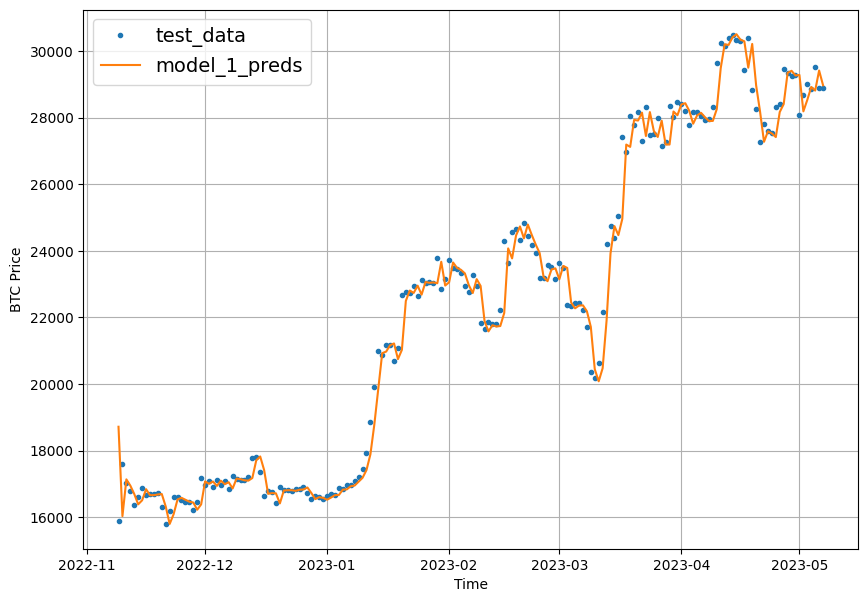

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 3538.39282, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 3538.39282 to 2812.55127, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 2812.55127 to 2203.80225, saving model to model_experiments/model_2_dense



Epoch 4: val_loss improved from 2203.80225 to 1798.87537, saving model to model_experiments/model_2_dense



Epoch 5: val_loss did not improve from 1798.87537

Epoch 6: val_loss improved from 1798.87537 to 1540.31702, saving model to model_experiments/model_2_dense



Epoch 7: val_loss did not improve from 1540.31702

Epoch 8: val_loss did not improve from 1540.31702

Epoch 9: val_loss did not improve from 1540.31702

Epoch 10: val_loss improved from 1540.31702 to 1396.16162, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1396.16162

Epoch 12: val_loss did not improve from 1396.16162

Epoch 13: val_loss did not improve from 1396.16162

Epoch 14: val_loss did not improve from 1396.16162

Epoch 15: val_loss improved from 1396.16162 to 1244.78967, saving model to model_experiments/model_2_dense



Epoch 16: val_loss improved from 1244.78967 to 1230.36035, saving model to model_experiments/model_2_dense



Epoch 17: val_loss improved from 1230.36035 to 1191.96875, saving model to model_experiments/model_2_dense



Epoch 18: val_loss improved from 1191.96875 to 1183.58704, saving model to model_experiments/model_2_dense



Epoch 19: val_loss improved from 1183.58704 to 1155.17078, saving model to model_experiments/model_2_dense



Epoch 20: val_loss did not improve from 1155.17078

Epoch 21: val_loss did not improve from 1155.17078

Epoch 22: val_loss did not improve from 1155.17078

Epoch 23: val_loss did not improve from 1155.17078

Epoch 24: val_loss did not improve from 1155.17078

Epoch 25: val_loss did not improve from 1155.17078

Epoch 26: val_loss did not improve from 1155.17078

Epoch 27: val_loss did not improve from 1155.17078

Epoch 28: val_loss did not improve from 1155.17078

Epoch 29: val_loss improved from 1155.17078 to 1062.95496, saving model to model_experiments/model_2_dense



Epoch 30: val_loss did not improve from 1062.95496

Epoch 31: val_loss did not improve from 1062.95496

Epoch 32: val_loss did not improve from 1062.95496

Epoch 33: val_loss improved from 1062.95496 to 1031.55859, saving model to model_experiments/model_2_dense



Epoch 34: val_loss did not improve from 1031.55859

Epoch 35: val_loss improved from 1031.55859 to 1011.10193, saving model to model_experiments/model_2_dense



Epoch 36: val_loss improved from 1011.10193 to 1005.76971, saving model to model_experiments/model_2_dense



Epoch 37: val_loss did not improve from 1005.76971

Epoch 38: val_loss did not improve from 1005.76971

Epoch 39: val_loss improved from 1005.76971 to 976.07861, saving model to model_experiments/model_2_dense



Epoch 40: val_loss did not improve from 976.07861

Epoch 41: val_loss did not improve from 976.07861

Epoch 42: val_loss did not improve from 976.07861

Epoch 43: val_loss did not improve from 976.07861

Epoch 44: val_loss did not improve from 976.07861

Epoch 45: val_loss improved from 976.07861 to 947.76208, saving model to model_experiments/model_2_dense



Epoch 46: val_loss did not improve from 947.76208

Epoch 47: val_loss did not improve from 947.76208

Epoch 48: val_loss improved from 947.76208 to 929.79669, saving model to model_experiments/model_2_dense



Epoch 49: val_loss did not improve from 929.79669

Epoch 50: val_loss did not improve from 929.79669

Epoch 51: val_loss improved from 929.79669 to 920.42108, saving model to model_experiments/model_2_dense



Epoch 52: val_loss did not improve from 920.42108

Epoch 53: val_loss did not improve from 920.42108

Epoch 54: val_loss did not improve from 920.42108

Epoch 55: val_loss did not improve from 920.42108

Epoch 56: val_loss improved from 920.42108 to 900.29901, saving model to model_experiments/model_2_dense



Epoch 57: val_loss did not improve from 900.29901

Epoch 58: val_loss improved from 900.29901 to 894.69531, saving model to model_experiments/model_2_dense



Epoch 59: val_loss did not improve from 894.69531

Epoch 60: val_loss did not improve from 894.69531

Epoch 61: val_loss did not improve from 894.69531

Epoch 62: val_loss did not improve from 894.69531

Epoch 63: val_loss did not improve from 894.69531

Epoch 64: val_loss did not improve from 894.69531

Epoch 65: val_loss did not improve from 894.69531

Epoch 66: val_loss improved from 894.69531 to 882.26862, saving model to model_experiments/model_2_dense



Epoch 67: val_loss did not improve from 882.26862

Epoch 68: val_loss improved from 882.26862 to 878.28198, saving model to model_experiments/model_2_dense



Epoch 69: val_loss improved from 878.28198 to 875.72882, saving model to model_experiments/model_2_dense



Epoch 70: val_loss did not improve from 875.72882

Epoch 71: val_loss did not improve from 875.72882

Epoch 72: val_loss did not improve from 875.72882

Epoch 73: val_loss did not improve from 875.72882

Epoch 74: val_loss did not improve from 875.72882

Epoch 75: val_loss did not improve from 875.72882

Epoch 76: val_loss improved from 875.72882 to 866.13678, saving model to model_experiments/model_2_dense



Epoch 77: val_loss did not improve from 866.13678

Epoch 78: val_loss did not improve from 866.13678

Epoch 79: val_loss did not improve from 866.13678

Epoch 80: val_loss did not improve from 866.13678

Epoch 81: val_loss did not improve from 866.13678

Epoch 82: val_loss did not improve from 866.13678

Epoch 83: val_loss did not improve from 866.13678

Epoch 84: val_loss did not improve from 866.13678

Epoch 85: val_loss did not improve from 866.13678

Epoch 86: val_loss did not improve from 866.13678

Epoch 87: val_loss improved from 866.13678 to 848.24341, saving model to model_experiments/model_2_dense



Epoch 88: val_loss did not improve from 848.24341

Epoch 89: val_loss did not improve from 848.24341

Epoch 90: val_loss did not improve from 848.24341

Epoch 91: val_loss did not improve from 848.24341

Epoch 92: val_loss did not improve from 848.24341

Epoch 93: val_loss improved from 848.24341 to 843.62512, saving model to model_experiments/model_2_dense



Epoch 94: val_loss did not improve from 843.62512

Epoch 95: val_loss did not improve from 843.62512

Epoch 96: val_loss did not improve from 843.62512

Epoch 97: val_loss did not improve from 843.62512

Epoch 98: val_loss did not improve from 843.62512

Epoch 99: val_loss improved from 843.62512 to 837.18787, saving model to model_experiments/model_2_dense



Epoch 100: val_loss did not improve from 837.18787


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 6ms/step - loss: 895.6702 - mse: 1681092.8750 - mae: 895.6702


[895.6702270507812, 1681092.875, 895.6702270507812]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 1s 7ms/step - loss: 837.1879 - mse: 1600647.7500 - mae: 837.1879


[837.1879272460938, 1600647.75, 837.1879272460938]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 6ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 837.1879,
 'mse': 1600647.6,
 'rmse': 1265.167,
 'mape': 2.4849348,
 'mase': 1.0967876}

In [59]:
model_1_results

{'mae': 775.5618,
 'mse': 1411270.2,
 'rmse': 1187.9689,
 'mape': 2.281636,
 'mase': 1.0106423}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

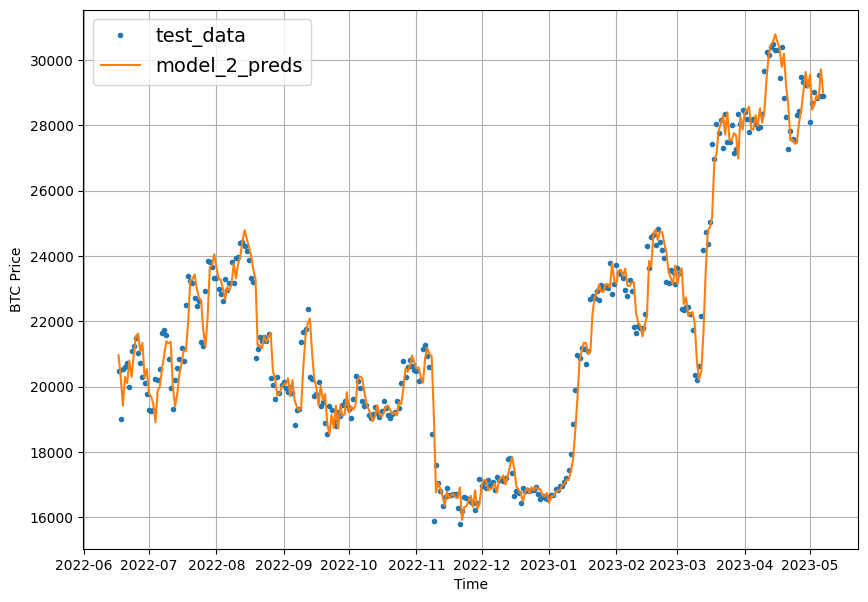

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 3666.58936, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 3666.58936 to 2179.59961, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2179.59961 to 2085.29053, saving model to model_experiments/model_3_dense



Epoch 4: val_loss did not improve from 2085.29053

Epoch 5: val_loss did not improve from 2085.29053

Epoch 6: val_loss improved from 2085.29053 to 2025.43494, saving model to model_experiments/model_3_dense



Epoch 7: val_loss improved from 2025.43494 to 1936.35132, saving model to model_experiments/model_3_dense



Epoch 8: val_loss improved from 1936.35132 to 1909.89502, saving model to model_experiments/model_3_dense



Epoch 9: val_loss did not improve from 1909.89502

Epoch 10: val_loss did not improve from 1909.89502

Epoch 11: val_loss did not improve from 1909.89502

Epoch 12: val_loss improved from 1909.89502 to 1884.62415, saving model to model_experiments/model_3_dense



Epoch 13: val_loss improved from 1884.62415 to 1879.27148, saving model to model_experiments/model_3_dense



Epoch 14: val_loss did not improve from 1879.27148

Epoch 15: val_loss did not improve from 1879.27148

Epoch 16: val_loss did not improve from 1879.27148

Epoch 17: val_loss improved from 1879.27148 to 1786.23120, saving model to model_experiments/model_3_dense



Epoch 18: val_loss improved from 1786.23120 to 1755.68591, saving model to model_experiments/model_3_dense



Epoch 19: val_loss did not improve from 1755.68591

Epoch 20: val_loss did not improve from 1755.68591

Epoch 21: val_loss did not improve from 1755.68591

Epoch 22: val_loss did not improve from 1755.68591

Epoch 23: val_loss improved from 1755.68591 to 1708.42224, saving model to model_experiments/model_3_dense



Epoch 24: val_loss did not improve from 1708.42224

Epoch 25: val_loss did not improve from 1708.42224

Epoch 26: val_loss did not improve from 1708.42224

Epoch 27: val_loss did not improve from 1708.42224

Epoch 28: val_loss did not improve from 1708.42224

Epoch 29: val_loss did not improve from 1708.42224

Epoch 30: val_loss improved from 1708.42224 to 1700.01306, saving model to model_experiments/model_3_dense



Epoch 31: val_loss did not improve from 1700.01306

Epoch 32: val_loss did not improve from 1700.01306

Epoch 33: val_loss improved from 1700.01306 to 1685.16907, saving model to model_experiments/model_3_dense



Epoch 34: val_loss did not improve from 1685.16907

Epoch 35: val_loss did not improve from 1685.16907

Epoch 36: val_loss did not improve from 1685.16907

Epoch 37: val_loss did not improve from 1685.16907

Epoch 38: val_loss did not improve from 1685.16907

Epoch 39: val_loss did not improve from 1685.16907

Epoch 40: val_loss did not improve from 1685.16907

Epoch 41: val_loss did not improve from 1685.16907

Epoch 42: val_loss did not improve from 1685.16907

Epoch 43: val_loss did not improve from 1685.16907

Epoch 44: val_loss did not improve from 1685.16907

Epoch 45: val_loss did not improve from 1685.16907

Epoch 46: val_loss did not improve from 1685.16907

Epoch 47: val_loss did not improve from 1685.16907

Epoch 48: val_loss did not improve from 1685.16907

Epoch 49: val_loss improved from 1685.16907 to 1651.35437, saving model to model_experiments/model_3_dense



Epoch 50: val_loss did not improve from 1651.35437

Epoch 51: val_loss did not improve from 1651.35437

Epoch 52: val_loss did not improve from 1651.35437

Epoch 53: val_loss did not improve from 1651.35437

Epoch 54: val_loss did not improve from 1651.35437

Epoch 55: val_loss did not improve from 1651.35437

Epoch 56: val_loss did not improve from 1651.35437

Epoch 57: val_loss did not improve from 1651.35437

Epoch 58: val_loss did not improve from 1651.35437

Epoch 59: val_loss did not improve from 1651.35437

Epoch 60: val_loss improved from 1651.35437 to 1639.33850, saving model to model_experiments/model_3_dense



Epoch 61: val_loss did not improve from 1639.33850

Epoch 62: val_loss did not improve from 1639.33850

Epoch 63: val_loss did not improve from 1639.33850

Epoch 64: val_loss did not improve from 1639.33850

Epoch 65: val_loss did not improve from 1639.33850

Epoch 66: val_loss did not improve from 1639.33850

Epoch 67: val_loss did not improve from 1639.33850

Epoch 68: val_loss did not improve from 1639.33850

Epoch 69: val_loss did not improve from 1639.33850

Epoch 70: val_loss did not improve from 1639.33850

Epoch 71: val_loss did not improve from 1639.33850

Epoch 72: val_loss did not improve from 1639.33850

Epoch 73: val_loss did not improve from 1639.33850

Epoch 74: val_loss improved from 1639.33850 to 1628.17468, saving model to model_experiments/model_3_dense



Epoch 75: val_loss improved from 1628.17468 to 1614.17920, saving model to model_experiments/model_3_dense



Epoch 76: val_loss did not improve from 1614.17920

Epoch 77: val_loss did not improve from 1614.17920

Epoch 78: val_loss did not improve from 1614.17920

Epoch 79: val_loss did not improve from 1614.17920

Epoch 80: val_loss did not improve from 1614.17920

Epoch 81: val_loss did not improve from 1614.17920

Epoch 82: val_loss did not improve from 1614.17920

Epoch 83: val_loss did not improve from 1614.17920

Epoch 84: val_loss did not improve from 1614.17920

Epoch 85: val_loss did not improve from 1614.17920

Epoch 86: val_loss did not improve from 1614.17920

Epoch 87: val_loss did not improve from 1614.17920

Epoch 88: val_loss did not improve from 1614.17920

Epoch 89: val_loss did not improve from 1614.17920

Epoch 90: val_loss did not improve from 1614.17920

Epoch 91: val_loss did not improve from 1614.17920

Epoch 92: val_loss did not improve from 1614.17920

Epoch 93: val_loss did not improve from 1614.17920

Epoch 94: val_loss did not improve from 1614.17920

Epoch 95: v


Epoch 100: val_loss did not improve from 1606.31274


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 1624.2128 - mae: 1624.2128 - mse: 5705791.0000


[1624.2127685546875, 1624.2127685546875, 5705791.0]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 1606.3127 - mae: 1606.3127 - mse: 5632404.5000


[1606.312744140625, 1606.312744140625, 5632404.5]

In [74]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47004.402, 47291.6  , 47262.18 , 46430.188, 47598.16 , 47392.566,
        47323.656],
       [45734.746, 46340.43 , 46053.742, 45974.04 , 46891.73 , 46793.09 ,
        46523.457],
       [44863.688, 45452.176, 45716.45 , 45518.438, 46481.574, 46288.113,
        46332.125],
       [45083.37 , 45022.68 , 45436.652, 45469.594, 46474.906, 46467.996,
        46499.523],
       [46093.31 , 46056.668, 47008.566, 46738.055, 47846.07 , 47774.926,
        48023.527]], dtype=float32)>

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

In [77]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [81]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [82]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1606.3127,
 'mse': 5632405.0,
 'rmse': 1844.5769,
 'mape': 4.857049,
 'mase': 2.09359}

In [86]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47004.402, 47291.6  , 47262.18 , 46430.188, 47598.16 , 47392.566,
        47323.656],
       [45734.746, 46340.43 , 46053.742, 45974.04 , 46891.73 , 46793.09 ,
        46523.457],
       [44863.688, 45452.176, 45716.45 , 45518.438, 46481.574, 46288.113,
        46332.125],
       [45083.37 , 45022.68 , 45436.652, 45469.594, 46474.906, 46467.996,
        46499.523],
       [46093.31 , 46056.668, 47008.566, 46738.055, 47846.07 , 47774.926,
        48023.527]], dtype=float32)>

In [91]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

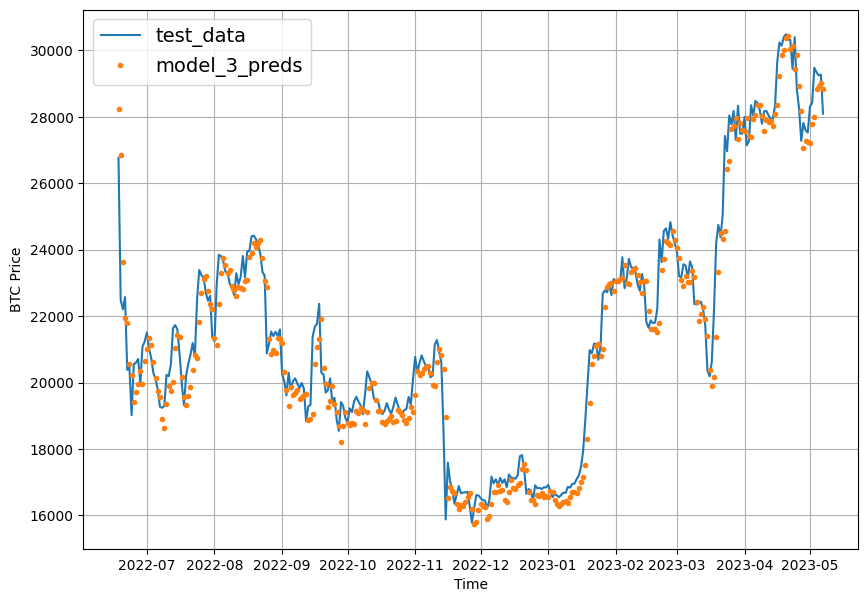

In [95]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

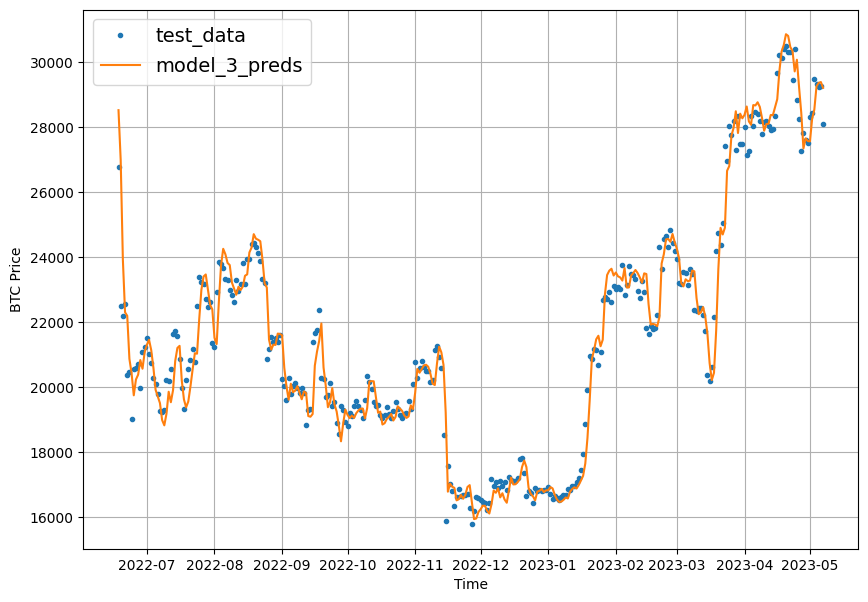

In [97]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

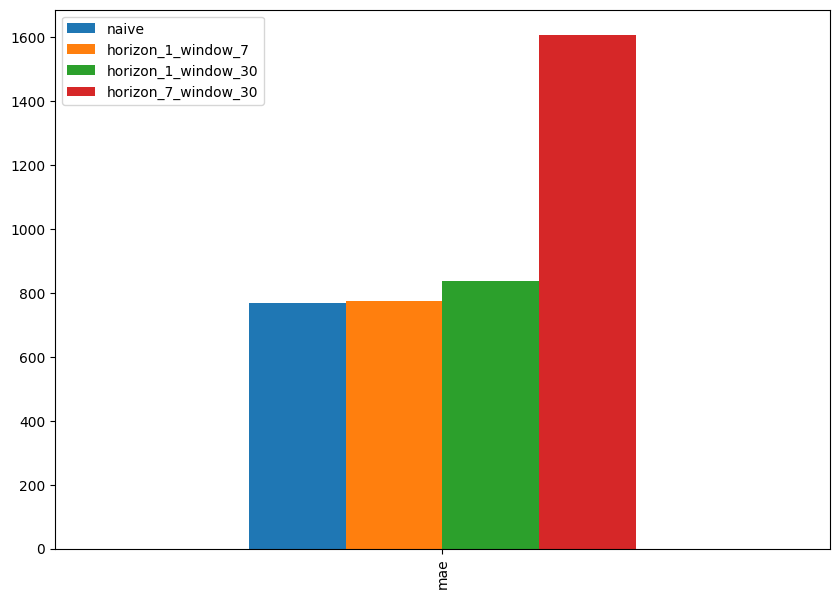

In [98]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [127]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [128]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [130]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [105]:
# Check data input shape
train_windows[0].shape

(7,)

In [107]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [108]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [109]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [145]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 4816.16016, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss improved from 4816.16016 to 1434.18274, saving model to model_experiments/model_4_conv1D



Epoch 3: val_loss did not improve from 1434.18274

Epoch 4: val_loss did not improve from 1434.18274

Epoch 5: val_loss improved from 1434.18274 to 1358.76392, saving model to model_experiments/model_4_conv1D



Epoch 6: val_loss improved from 1358.76392 to 1319.46826, saving model to model_experiments/model_4_conv1D



Epoch 7: val_loss improved from 1319.46826 to 1309.11853, saving model to model_experiments/model_4_conv1D



Epoch 8: val_loss did not improve from 1309.11853

Epoch 9: val_loss improved from 1309.11853 to 1307.63855, saving model to model_experiments/model_4_conv1D



Epoch 10: val_loss improved from 1307.63855 to 1235.35059, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss did not improve from 1235.35059

Epoch 12: val_loss improved from 1235.35059 to 1218.40161, saving model to model_experiments/model_4_conv1D



Epoch 13: val_loss improved from 1218.40161 to 1184.73267, saving model to model_experiments/model_4_conv1D



Epoch 14: val_loss did not improve from 1184.73267

Epoch 15: val_loss improved from 1184.73267 to 1154.46350, saving model to model_experiments/model_4_conv1D



Epoch 16: val_loss improved from 1154.46350 to 1151.01355, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1151.01355

Epoch 18: val_loss did not improve from 1151.01355

Epoch 19: val_loss improved from 1151.01355 to 1051.69678, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss did not improve from 1051.69678

Epoch 21: val_loss improved from 1051.69678 to 996.66327, saving model to model_experiments/model_4_conv1D



Epoch 22: val_loss did not improve from 996.66327

Epoch 23: val_loss did not improve from 996.66327

Epoch 24: val_loss did not improve from 996.66327

Epoch 25: val_loss improved from 996.66327 to 952.08380, saving model to model_experiments/model_4_conv1D



Epoch 26: val_loss improved from 952.08380 to 932.61694, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss did not improve from 932.61694

Epoch 28: val_loss did not improve from 932.61694

Epoch 29: val_loss did not improve from 932.61694

Epoch 30: val_loss did not improve from 932.61694

Epoch 31: val_loss improved from 932.61694 to 886.99030, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 886.99030

Epoch 33: val_loss improved from 886.99030 to 883.33063, saving model to model_experiments/model_4_conv1D



Epoch 34: val_loss did not improve from 883.33063

Epoch 35: val_loss improved from 883.33063 to 876.73254, saving model to model_experiments/model_4_conv1D



Epoch 36: val_loss did not improve from 876.73254

Epoch 37: val_loss did not improve from 876.73254

Epoch 38: val_loss did not improve from 876.73254

Epoch 39: val_loss did not improve from 876.73254

Epoch 40: val_loss improved from 876.73254 to 862.36823, saving model to model_experiments/model_4_conv1D



Epoch 41: val_loss improved from 862.36823 to 858.96436, saving model to model_experiments/model_4_conv1D



Epoch 42: val_loss improved from 858.96436 to 856.39899, saving model to model_experiments/model_4_conv1D



Epoch 43: val_loss did not improve from 856.39899

Epoch 44: val_loss did not improve from 856.39899

Epoch 45: val_loss did not improve from 856.39899

Epoch 46: val_loss did not improve from 856.39899

Epoch 47: val_loss did not improve from 856.39899

Epoch 48: val_loss improved from 856.39899 to 845.29535, saving model to model_experiments/model_4_conv1D



Epoch 49: val_loss improved from 845.29535 to 844.26074, saving model to model_experiments/model_4_conv1D



Epoch 50: val_loss improved from 844.26074 to 840.98053, saving model to model_experiments/model_4_conv1D



Epoch 51: val_loss did not improve from 840.98053

Epoch 52: val_loss did not improve from 840.98053

Epoch 53: val_loss did not improve from 840.98053

Epoch 54: val_loss did not improve from 840.98053

Epoch 55: val_loss did not improve from 840.98053

Epoch 56: val_loss did not improve from 840.98053

Epoch 57: val_loss improved from 840.98053 to 835.84283, saving model to model_experiments/model_4_conv1D



Epoch 58: val_loss did not improve from 835.84283

Epoch 59: val_loss improved from 835.84283 to 827.20245, saving model to model_experiments/model_4_conv1D



Epoch 60: val_loss did not improve from 827.20245

Epoch 61: val_loss did not improve from 827.20245

Epoch 62: val_loss did not improve from 827.20245

Epoch 63: val_loss did not improve from 827.20245

Epoch 64: val_loss did not improve from 827.20245

Epoch 65: val_loss did not improve from 827.20245

Epoch 66: val_loss did not improve from 827.20245

Epoch 67: val_loss did not improve from 827.20245

Epoch 68: val_loss did not improve from 827.20245

Epoch 69: val_loss did not improve from 827.20245

Epoch 70: val_loss did not improve from 827.20245

Epoch 71: val_loss did not improve from 827.20245

Epoch 72: val_loss improved from 827.20245 to 817.53644, saving model to model_experiments/model_4_conv1D



Epoch 73: val_loss did not improve from 817.53644

Epoch 74: val_loss did not improve from 817.53644

Epoch 75: val_loss did not improve from 817.53644

Epoch 76: val_loss did not improve from 817.53644

Epoch 77: val_loss did not improve from 817.53644

Epoch 78: val_loss improved from 817.53644 to 817.37128, saving model to model_experiments/model_4_conv1D



Epoch 79: val_loss did not improve from 817.37128

Epoch 80: val_loss improved from 817.37128 to 807.12518, saving model to model_experiments/model_4_conv1D



Epoch 81: val_loss did not improve from 807.12518

Epoch 82: val_loss did not improve from 807.12518

Epoch 83: val_loss improved from 807.12518 to 804.74402, saving model to model_experiments/model_4_conv1D



Epoch 84: val_loss did not improve from 804.74402

Epoch 85: val_loss did not improve from 804.74402

Epoch 86: val_loss did not improve from 804.74402

Epoch 87: val_loss did not improve from 804.74402

Epoch 88: val_loss did not improve from 804.74402

Epoch 89: val_loss improved from 804.74402 to 801.74463, saving model to model_experiments/model_4_conv1D



Epoch 90: val_loss did not improve from 801.74463

Epoch 91: val_loss did not improve from 801.74463

Epoch 92: val_loss did not improve from 801.74463

Epoch 93: val_loss improved from 801.74463 to 799.92767, saving model to model_experiments/model_4_conv1D



Epoch 94: val_loss improved from 799.92767 to 798.78046, saving model to model_experiments/model_4_conv1D



Epoch 95: val_loss did not improve from 798.78046

Epoch 96: val_loss did not improve from 798.78046

Epoch 97: val_loss did not improve from 798.78046

Epoch 98: val_loss did not improve from 798.78046

Epoch 99: val_loss did not improve from 798.78046

Epoch 100: val_loss did not improve from 798.78046


In [146]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 891.4607 - mae: 891.4607 - mse: 1731619.1250


[891.460693359375, 891.460693359375, 1731619.125]

In [147]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 798.7805 - mae: 798.7805 - mse: 1500798.0000


[798.780517578125, 798.780517578125, 1500798.0]

In [148]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47208.434, 46245.863, 44834.863, 44634.32 , 46088.258, 48846.484,
       49326.44 , 49443.676, 49601.34 , 48220.055], dtype=float32)>

In [149]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 798.7806,
 'mse': 1500798.2,
 'rmse': 1225.0707,
 'mape': 2.3508794,
 'mase': 1.0408988}

In [150]:
model_1_results

{'mae': 775.5618,
 'mse': 1411270.2,
 'rmse': 1187.9689,
 'mape': 2.281636,
 'mase': 1.0106423}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [154]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
18/20 [==========================>...] - ETA: 0s - loss: 7627.2910
Epoch 1: val_loss improved from inf to 23151.28320, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 5s 115ms/step - loss: 7665.5161 - val_loss: 23151.2832
Epoch 2/100
16/20 [=======================>......] - ETA: 0s - loss: 4996.2817
Epoch 2: val_loss improved from 23151.28320 to 11106.68457, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 103ms/step - loss: 4681.0991 - val_loss: 11106.6846
Epoch 3/100
16/20 [=======================>......] - ETA: 0s - loss: 1584.5128
Epoch 3: val_loss improved from 11106.68457 to 3062.98193, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 3s 141ms/step - loss: 1399.3051 - val_loss: 3062.9819
Epoch 4/100
18/20 [==========================>...] - ETA: 0s - loss: 618.4625
Epoch 4: val_loss improved from 3062.98193 to 1453.53271, saving model to model_experi

Exception ignored in: <function _xla_gc_callback at 0x7f29c91480d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


20/20 [==============================] - 54s 3s/step - loss: 484.4163 - val_loss: 1393.4691
Epoch 11/100
18/20 [==========================>...] - ETA: 0s - loss: 478.0846
Epoch 11: val_loss did not improve from 1393.46912
20/20 [==============================] - 0s 18ms/step - loss: 483.7456 - val_loss: 1409.2272
Epoch 12/100
17/20 [========================>.....] - ETA: 0s - loss: 479.1602
Epoch 12: val_loss did not improve from 1393.46912
20/20 [==============================] - 0s 17ms/step - loss: 478.8561 - val_loss: 1452.5018
Epoch 13/100
17/20 [========================>.....] - ETA: 0s - loss: 480.1960
Epoch 13: val_loss did not improve from 1393.46912
20/20 [==============================] - 0s 17ms/step - loss: 479.2667 - val_loss: 1469.7150
Epoch 14/100
17/20 [========================>.....] - ETA: 0s - loss: 469.4813
Epoch 14: val_loss did not improve from 1393.46912
20/20 [==============================] - 0s 17ms/step - loss: 474.2220 - val_loss: 1554.5074
Epoch 15/100
17/

In [155]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 6ms/step - loss: 823.7866


823.7865600585938

In [160]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47349.766, 46575.63 , 45554.434, 44802.26 , 46082.676],
      dtype=float32)>

In [162]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 823.78656,
 'mse': 1548369.1,
 'rmse': 1244.3348,
 'mape': 2.435039,
 'mase': 1.0734844}

In [163]:
model_1_results

{'mae': 775.5618,
 'mse': 1411270.2,
 'rmse': 1187.9689,
 'mape': 2.281636,
 'mase': 1.0106423}